<a href="https://colab.research.google.com/github/navneethosmane1499/Googled-Lens/blob/master/ResNet50DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, cohen_kappa_score

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_df = pd.read_csv('/content/drive/MyDrive/train_df.csv')
test_data_df = pd.read_csv('/content/drive/MyDrive/test_df.csv')
train_data_df['diagnosis'] = train_data_df['diagnosis'].apply(str)
train_data_df.head()

,Unnamed: 0,id_code,file_path,file_name,diagnosis
0,0,add1d681d712,/content/drive/MyDrive/processed_trained_image...,add1d681d712.png,2
1,1,05e9126dfa5c,/content/drive/MyDrive/processed_trained_image...,05e9126dfa5c.png,0
2,2,8958a4d17b7e,/content/drive/MyDrive/processed_trained_image...,8958a4d17b7e.png,3
3,3,67844c46bc61,/content/drive/MyDrive/processed_trained_image...,67844c46bc61.png,2
4,4,6cdd0f985270,/content/drive/MyDrive/processed_trained_image...,6cdd0f985270.png,1


In [ ]:
# Model parameters
BATCH_SIZE = 32
EPOCHS = 30

LEARNING_RATE = 1e-4
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train_data_df['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
def kappa(y_true, y_pred, n_classes=5):
    y_trues = K.cast(K.argmax(y_true), K.floatx())
    y_preds = K.cast(K.argmax(y_pred), K.floatx())
    n_samples = K.cast(K.shape(y_true)[0], K.floatx())
    distance = K.sum(K.abs(y_trues - y_preds))
    max_distance = n_classes - 1

    kappa_score = 1 - ((distance**2) / (n_samples * (max_distance**2)))

    return kappa_score

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_data_df,
    directory="/content/drive/MyDrive/processed_trained_images",
    x_col="file_name",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_data_df,
    directory="/content/drive/MyDrive/processed_trained_images",
    x_col="file_name",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test_data_df,
        directory = "/content/drive/MyDrive/processed_test_images",
        x_col="file_name",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1918 validated image filenames.


In [ ]:
def create_model(ip_shape, n_out):
    ip_tensor = Input(shape=ip_shape)

    base_model = ResNet50(weights=None, include_top=False, input_tensor=ip_tensor)
    base_model.load_weights('/content/drive/MyDrive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
  
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(ip_tensor, final_output)
    
    return model

In [ ]:
def create_class_weight(labels_dict, mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

In [ ]:
model = create_model(ip_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
    
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_data_df['diagnosis'].astype('int').values), train_data_df['diagnosis'].astype('int').values)

metric_list = ["accuracy", kappa]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
classes = [0, 1, 2, 3, 4]
weights = dict(zip(classes, class_weights))

class_wt = create_class_weight(weights)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_kappa', mode='max', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_kappa', mode='max', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
history_finetuning = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              class_weight=class_wt,
                              callbacks= callback_list,
                              verbose=1).history
model.save("/content/drive/MyDrive/models/")

Epoch 1/30
91/91 [==============================] - 80s 876ms/step - loss: 0.0476 - accuracy: 0.9827 - kappa: 0.9968 - val_loss: 1.2885 - val_accuracy: 0.8139 - val_kappa: 0.8454
Epoch 2/30
91/91 [==============================] - 80s 878ms/step - loss: 0.0248 - accuracy: 0.9879 - kappa: 0.9975 - val_loss: 1.1554 - val_accuracy: 0.8196 - val_kappa: 0.8516
Epoch 3/30
91/91 [==============================] - 80s 872ms/step - loss: 0.0557 - accuracy: 0.9803 - kappa: 0.9964 - val_loss: 1.3214 - val_accuracy: 0.7727 - val_kappa: 0.7886
Epoch 4/30
91/91 [==============================] - 80s 874ms/step - loss: 0.0458 - accuracy: 0.9817 - kappa: 0.9968 - val_loss: 1.6853 - val_accuracy: 0.7940 - val_kappa: 0.8020
Epoch 5/30
91/91 [==============================] - 80s 873ms/step - loss: 0.0431 - accuracy: 0.9841 - kappa: 0.9965 - val_loss: 2.4192 - val_accuracy: 0.7869 - val_kappa: 0.7725
Epoch 6/30
91/91 [==============================] - 80s 876ms/step - loss: 0.0671 - accuracy: 0.9748 - ka

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history_finetuning['accuracy'])
plt.plot(history_finetuning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

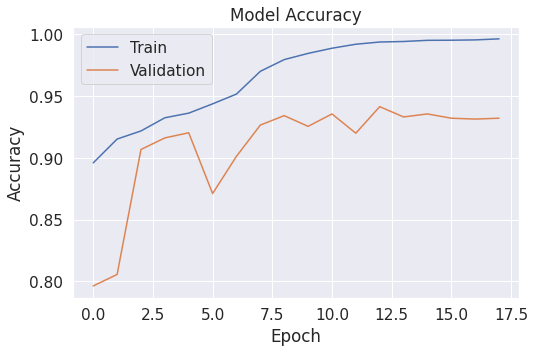


In [ ]:
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

thr=0.210 F2=0.683


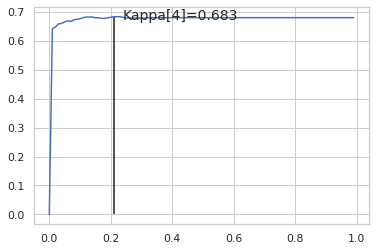

thr=0.370 F2=0.680


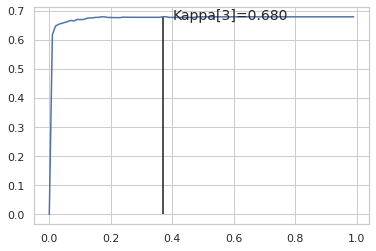

thr=0.300 F2=0.691


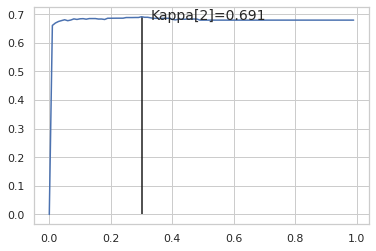

thr=0.490 F2=0.680


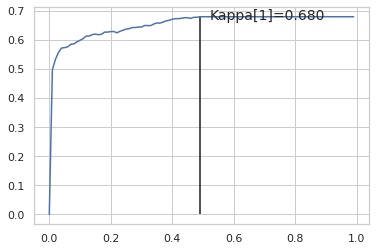

thr=0.340 F2=0.684


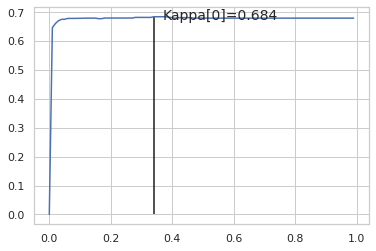

In [ ]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    best_thr_list = [0 for i in range(preds.shape[1])]
    for index in reversed(range(preds.shape[1])):
        score = []
        thrs = np.arange(0, 1, 0.01)
        for thr in thrs:
            preds_thr = [index if x[index] > thr else np.argmax(x) for x in preds]
            score.append(cohen_kappa_score(targs, preds_thr))
        score = np.array(score)
        pm = score.argmax()
        best_thr, best_score = thrs[pm], score[pm].item()
        best_thr_list[index] = best_thr
        print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
        if do_plot:
            plt.plot(thrs, score)
            plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
            plt.text(best_thr+0.03, best_score-0.01, ('Kappa[%s]=%.3f'%(index, best_score)), fontsize=14);
            plt.show()
    return best_thr_list

threshold_list = find_best_fixed_threshold(lastFullValPred, validation_labels, do_plot=True)
threshold_list[0] = 0 # In last instance assign label 0

train_preds_opt = [0 for i in range(lastFullTrainPred.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(lastFullTrainPred):
        if pred[idx] > thr:
            train_preds_opt[idx2] = idx

validation_preds_opt = [0 for i in range(lastFullValPred.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(lastFullValPred):
        if pred[idx] > thr:
            validation_preds_opt[idx2] = idx

Text(0.5, 1.0, 'Validation')

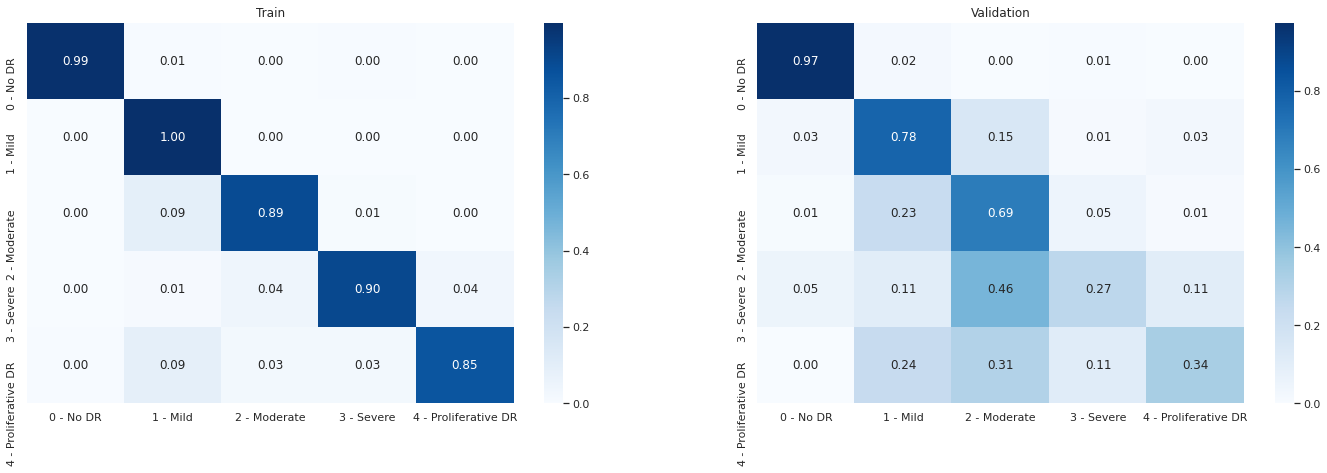

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax2).set_title('Validation')

Text(0.5, 1.0, 'Validation optimized')

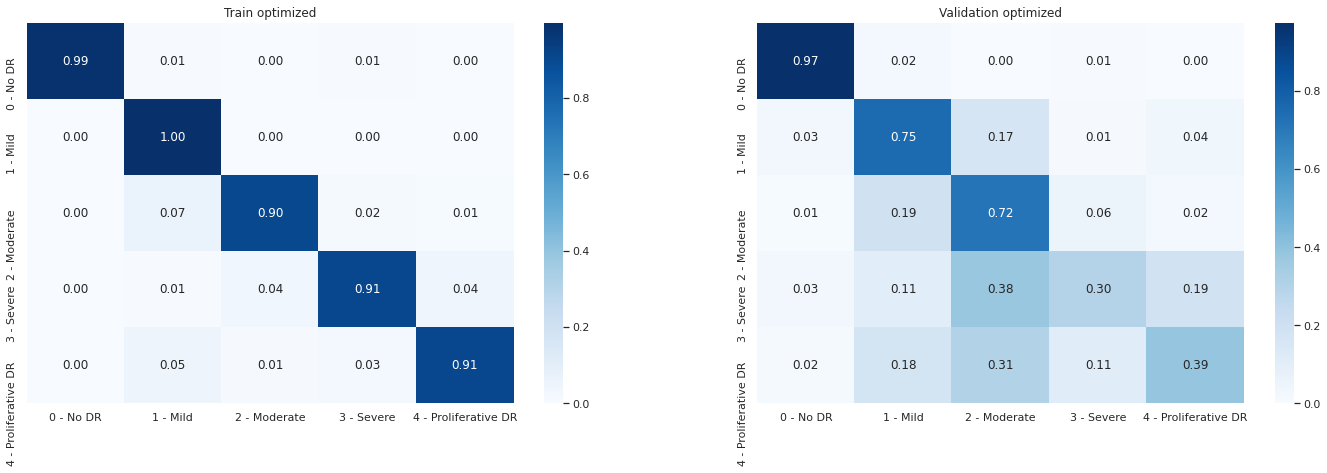

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds_opt)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds_opt)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train optimized')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax2).set_title('Validation optimized')

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))
print("Train optimized Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds_opt, train_labels, weights='quadratic'))
print("Validation optimized Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds_opt, validation_labels, weights='quadratic'))
print("Complete optimized set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds_opt+validation_preds_opt, train_labels+validation_labels, weights='quadratic'))

Train Cohen Kappa score: 0.957
Validation Cohen Kappa score: 0.812
Complete set Cohen Kappa score: 0.930
Train optimized Cohen Kappa score: 0.966
Validation optimized Cohen Kappa score: 0.827
Complete optimized set Cohen Kappa score: 0.940


In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

predictions_opt = [0 for i in range(preds.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(preds):
        if pred[idx] > thr:
            predictions_opt[idx2] = idx

filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

results_opt = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions_opt})
results_opt['id_code'] = results_opt['id_code'].map(lambda x: str(x)[:-4])

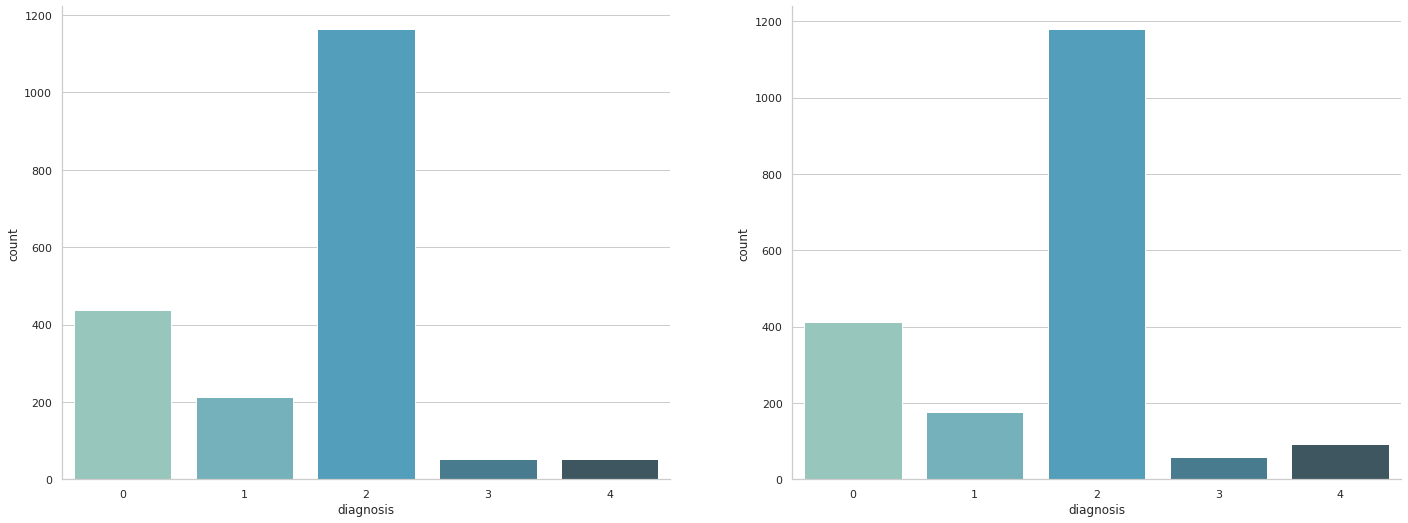

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d", ax=ax1)
sns.countplot(x="diagnosis", data=results_opt, palette="GnBu_d", ax=ax2)
sns.despine()
plt.show()